## Creating supermarkt-grid

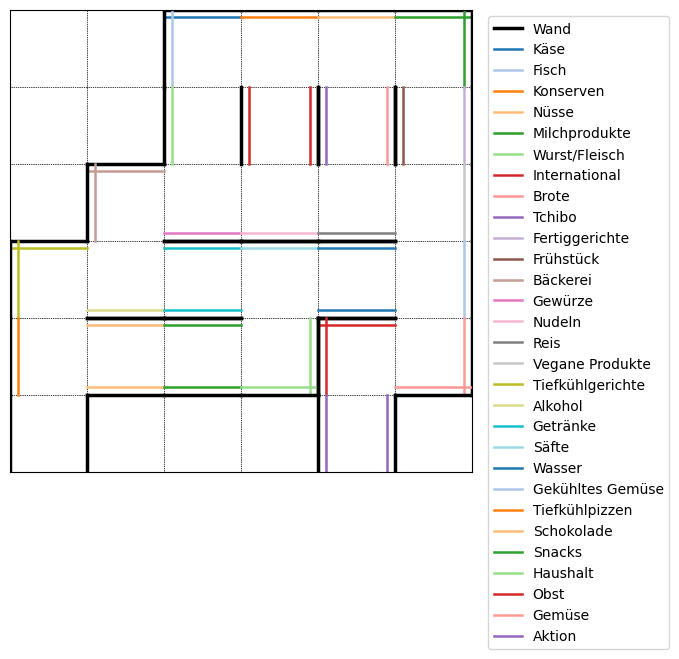

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

class Zelle:
    def __init__(self, row, column, width, height, N, E, S, W):
        # N,E,S,W können sein: 0 (Gang), 1 (Wand), str (Regaltyp)
        self.seiten = {"N": N, "E": E, "S": S, "W": W}
        self.row = row
        self.column = column
        self.width = width
        self.height = height
        
    def save(self):
        text = str(self.row) + ", " + str(self.column) + ", " + str(self.seiten)
        return text


def plot_grid(grid, person_path = []):
    fig, ax = plt.subplots(figsize=(6, 6))
    rows, cols = grid.shape

    # Farben je Regaltyp sammeln (automatisch)
    regal_colors = {}
    color_cycle = plt.cm.tab20.colors
    color_idx = 0

    for r in range(rows):
        for c in range(cols):
            z = grid[r, c]
            x = c * z.width
            y = (rows - 1 - r) * z.height
            
            # Zelle zeichnen (Umriss)
            rect = Rectangle((x, y), z.width, z.height,
                             fill=False, edgecolor="black", linewidth=0.5,
                             linestyle=":")
            ax.add_patch(rect)

            # Jede Seite logik
            for side, val in z.seiten.items():
                # Koordinaten der Seite bestimmen
                if side == "N":
                    x0, x1 = x, x + z.width
                    y0 = y1 = y + z.height
                    offset = -0.1 * z.height
                elif side == "S":
                    x0, x1 = x, x + z.width
                    y0 = y1 = y
                    offset = 0.1 * z.height
                elif side == "E":
                    x0 = x1 = x + z.width
                    y0, y1 = y, y + z.height
                    offset = -0.1 * z.width
                elif side == "W":
                    x0 = x1 = x
                    y0, y1 = y, y + z.height
                    offset = 0.1 * z.width
                else:
                    continue

                # Fall 1: Gang (0) -> nichts zeichnen
                if val == 0:
                    continue

                # Fall 2: Wand (1) -> dicke schwarze Linie
                if val == 1:
                    ax.plot([x0, x1], [y0, y1], linewidth=2.5, color="black")
                    continue

                # Fall 3: Regal (str) -> eingezogene gefärbte Linie
                if isinstance(val, str):
                    # Farbe zuordnen
                    if val not in regal_colors:
                        regal_colors[val] = color_cycle[color_idx % len(color_cycle)]
                        color_idx += 1

                    col = regal_colors[val]

                    # Auch Wand zeichnen
                    ax.plot([x0, x1], [y0, y1], linewidth=2.5, color="black")

                    # Eingeschobene Linie: je nach Richtung verschieben
                    if side in ["N", "S"]:
                        ax.plot([x0, x1], [y0 + offset, y1 + offset],
                                linewidth=1.8, color=col)
                    else:
                        ax.plot([x0 + offset, x1 + offset], [y0, y1],
                                linewidth=1.8, color=col)

    if person_path is not []:
        for path in person_path:
            path_x = [c + 0.5 for r, c in path]  # +0.5 für Zellmitte
            path_y = [grid.shape[0] - 1 - r + 0.5 for r, c in path]  # matplotlib y-Umkehr
            ax.plot(path_x, path_y, linewidth=2, linestyle="--")

    # Achsen konfigurieren
    ax.set_aspect("equal")
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks([])
    ax.set_yticks([])

    # Legende erzeugen
    legend_elements = [Line2D([0], [0], color='black', lw=2.5, label="Wand")]
    for name, col in regal_colors.items():
        legend_elements.append(
            Line2D([0], [0], color=col, lw=1.8, label=f"{name}")
        )
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1),loc="upper left")

    #plt.show()

def save_grid(grid, save_path):
    text = ""
    grid_shape = grid.shape
    for r in range(grid_shape[0]):
        for c in range(grid_shape[1]):
            cell_text = grid[r,c].save()
            text += cell_text
            text += "\n"
    with open(save_path, "w", encoding="utf-8") as f:
        f.write(text)

def create_grid(grid_size):
    grid = np.empty(grid_size, dtype=object)
    for r in range(grid_size[0]):
        for c in range(grid_size[1]):
            grid[r, c] = Zelle(row = r, column = c, width = 1, height = 1, N=0, E=0, S=0, W=0)
    return grid

def load_grid(path):
    # Datei einlesen
    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # Erst Größe bestimmen
    # Jede Zeile hat Format: "r, c, {dict}"
    coords = []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        left, right = line.split(",", 1)  # r und Rest
        r = int(left.strip())
        # zweite Zahl extrahieren
        c_str, rest = right.split(",", 1)
        c = int(c_str.strip())
        coords.append((r, c))

    if not coords:
        raise ValueError("Datei ist leer.")

    max_r = max(r for r, _ in coords)
    max_c = max(c for _, c in coords)
    rows = max_r + 1
    cols = max_c + 1

    # Grid anlegen
    grid = np.empty((rows, cols), dtype=object)
    for r in range(rows):
        for c in range(cols):
            grid[r, c] = Zelle(row=r, column=c, width=1, height=1, N=0, E=0, S=0, W=0)

    # Inhalte füllen
    for line in lines:
        line = line.strip()
        if not line:
            continue

        # Zerlegen
        # Beispiel: "0, 2, {'N': 'Käse', 'E': 0, 'S': 0, 'W': 'Fisch'}"
        parts = line.split(",", 2)
        r = int(parts[0].strip())
        c = int(parts[1].strip())

        # Dictionary-String bereinigen
        dict_str = parts[2].strip()
        # dict_str beginnt mit "{'N': ..." -> direkt evaluierbar
        seiten = eval(dict_str)  # hier ok, da Format unter eigener Kontrolle

        # In grid schreiben
        z = grid[r, c]
        z.seiten = seiten

    return grid


# Beispiel-Grid erzeugen
grid_size = (6,6)
grid = create_grid(grid_size)


# Beispiel-Konfiguration
# Zeile 1
grid[0,2].seiten["N"] = "Käse"
grid[0,2].seiten["W"] = "Fisch"
grid[0,3].seiten["N"] = "Konserven"
grid[0,4].seiten["N"] = "Nüsse"
grid[0,5].seiten["N"] = "Milchprodukte"
grid[0,5].seiten["E"] = "Milchprodukte"

# Zeile 2
grid[1,2].seiten["W"] = "Wurst/Fleisch"
grid[1,3].seiten["W"] = "International"
grid[1,3].seiten["E"] = "International"
grid[1,4].seiten["W"] = "Tchibo"
grid[1,4].seiten["E"] = "Brote"
grid[1,5].seiten["W"] = "Frühstück"
grid[1,5].seiten["E"] = "Fertiggerichte"

# Zeile 3
grid[2,1].seiten["W"] = "Bäckerei"
grid[2,1].seiten["N"] = "Bäckerei"
grid[2,2].seiten["S"] = "Gewürze"
grid[2,3].seiten["S"] = "Nudeln"
grid[2,4].seiten["S"] = "Reis"
grid[2,5].seiten["E"] = "Vegane Produkte"

# Zeile 4
grid[3,0].seiten["W"] = "Tiefkühlgerichte"
grid[3,0].seiten["N"] = "Tiefkühlgerichte"
grid[3,1].seiten["S"] = "Alkohol"
grid[3,2].seiten["N"] = "Getränke"
grid[3,2].seiten["S"] = "Getränke"
grid[3,3].seiten["N"] = "Säfte"
grid[3,4].seiten["N"] = "Wasser"
grid[3,4].seiten["S"] = "Wasser"
grid[3,5].seiten["E"] = "Gekühltes Gemüse"

# Zeile 5
grid[4,0].seiten["W"] = "Tiefkühlpizzen"
grid[4,1].seiten["N"] = "Schokolade"
grid[4,1].seiten["S"] = "Schokolade"
grid[4,2].seiten["N"] = "Snacks"
grid[4,2].seiten["S"] = "Snacks"
grid[4,3].seiten["E"] = "Haushalt"
grid[4,3].seiten["S"] = "Haushalt"
grid[4,4].seiten["N"] = "Obst"
grid[4,4].seiten["W"] = "Obst"
grid[4,5].seiten["E"] = "Gemüse"
grid[4,5].seiten["S"] = "Gemüse"

# Zeile 6
grid[5,0].seiten["E"] = 1
grid[5,0].seiten["W"] = 1
grid[5,4].seiten["E"] = "Aktion"
grid[5,4].seiten["W"] = "Aktion"
      

plot_grid(grid)
save_grid(grid, "grid.txt")


## A*-Algorithm

In [4]:
from heapq import heappush, heappop

def astar(grid, start, goal):
    rows, cols = grid.shape
    
    def neighbors(r, c):
        for dr, dc in [(1,0),(-1,0),(0,1),(0,-1)]:
            nr, nc = r+dr, c+dc
            if 0 <= nr < rows and 0 <= nc < cols:
                # nur begehbar wenn kein Regal/Wand dazwischen
                if is_passable(grid, r, c, nr, nc):
                    yield nr, nc

    def heuristic(r, c, gr, gc):
        return abs(r-gr) + abs(c-gc)   # Manhattan
    
    (sr, sc) = start
    (gr, gc) = goal

    open_set = []
    heappush(open_set, (0, sr, sc))
    came_from = {}
    g_score = {(sr, sc): 0}

    while open_set:
        _, r, c = heappop(open_set)

        if (r, c) == (gr, gc):
            return reconstruct_path(came_from, start, goal)

        for nr, nc in neighbors(r, c):
            tentative = g_score[(r, c)] + 1
            if (nr, nc) not in g_score or tentative < g_score[(nr, nc)]:
                g_score[(nr, nc)] = tentative
                f = tentative + heuristic(nr, nc, gr, gc)
                heappush(open_set, (f, nr, nc))
                came_from[(nr, nc)] = (r, c)

    return None  # Kein Weg gefunden


def reconstruct_path(came_from, start, goal):
    path = [goal]
    while path[-1] != start:
        path.append(came_from[path[-1]])
    path.reverse()
    return path


def is_passable(grid, r1, c1, r2, c2):
    """Begehbarkeit: blockiert wenn Wand(1) oder Regal(str) auf der Verbindungsseite."""
    z1 = grid[r1, c1]
    z2 = grid[r2, c2]

    # Richtung bestimmen
    if r2 == r1+1 and c2 == c1:
        # r1,c1 -> r2,c2 = nach unten in Grid-Koordinaten
        return z1.seiten["S"] == 0 and z2.seiten["N"] == 0
    if r2 == r1-1 and c2 == c1:
        return z1.seiten["N"] == 0 and z2.seiten["S"] == 0
    if r2 == r1 and c2 == c1+1:
        return z1.seiten["E"] == 0 and z2.seiten["W"] == 0
    if r2 == r1 and c2 == c1-1:
        return z1.seiten["W"] == 0 and z2.seiten["E"] == 0

    return False


## Computing Cost-/Path-Matrix for the different product-types

In [5]:
def compute_product_types_dict(grid, start_cell, end_cell):
    """
    Creates a dictionary mapping each product type in the grid to its cell coordinates.

    Keys:
        - "start": The starting cell (start_cell parameter)
        - "end": The ending cell (end_cell parameter)
        - All product types (as strings) found in the grid cells

    Values:
        - For "start" and "end": the coordinates (row, column) of the respective cell
        - For product types: a tuple (row, column) indicating the cell where the product type is located

    Procedure:
        1. Iterates over all cells in the 2D grid.
        2. Checks each side of the cell (N, E, S, W).
        3. If a side contains a product type (string), it is added as a key to the dictionary,
           with the value being the coordinates of the cell.
        4. Start and end cells are added as separate keys.

    Returns:
        - Dictionary containing start, end, and all found product types with their locations.
    """
    dict = {}
    dict["start"] = start_cell
    for (r, c), cell in np.ndenumerate(grid):
        assert type(cell) == Zelle
        seiten = cell.seiten
        products_in_cell = []
        if type(seiten["N"]) == str:
            products_in_cell.append(seiten["N"])
        if type(seiten["E"]) == str:
            products_in_cell.append(seiten["E"])
        if type(seiten["S"]) == str:
            products_in_cell.append(seiten["S"])
        if type(seiten["W"]) == str:
            products_in_cell.append(seiten["W"])
        
        for product in products_in_cell:
            dict[product] = (r,c)
    dict["end"] = end_cell
    return dict

def compute_optimal_trajectories(grid, start_cell, end_cell):
    """
    Computes the optimal trajectories and their costs between all product types, 
    including the start and end cells, in a grid using the A* algorithm.

    Procedure:
        1. Generates a dictionary of product types and their cell coordinates 
           using `compute_product_types_dict`.
        2. Assigns a unique index to each product type for matrix representation.
        3. Initializes two square matrices:
            - `product_type_cost_matrix`: stores the path length (cost) between each pair of product types
            - `product_type_path_matrix`: stores the actual path (list of cell coordinates) between each pair
        4. Iterates over all pairs of product types (including start and end) and computes the shortest path 
           using the `astar` function.
        5. Stores the path cost and the path itself in the corresponding matrices.

    Returns:
        - product_type_cost_matrix: 2D NumPy array with path lengths between all product types
        - product_type_path_matrix: 2D NumPy array with paths (lists of coordinates) between all product types
        - product_type_indizes: dictionary mapping product type names to their matrix indices
    """
    product_types_dict = compute_product_types_dict(grid, start_cell, end_cell)
    number_of_product_types = len(product_types_dict)
    product_type_cost_matrix = np.empty((number_of_product_types, number_of_product_types), dtype=object)
    product_type_path_matrix = np.empty((number_of_product_types, number_of_product_types), dtype=object)
    product_type_indizes = {}
    i = 0
    for product in product_types_dict:
        product_type_indizes[product] = i
        i += 1
    for product_start in product_types_dict:
        for product_end in product_types_dict:
            path = astar(grid, product_types_dict[product_start], product_types_dict[product_end])
            if path is not None:
                cost = len(path)-1
                product_type_cost_matrix[product_type_indizes[product_start], product_type_indizes[product_end]] = cost
                product_type_path_matrix[product_type_indizes[product_start], product_type_indizes[product_end]] = path
                #print(product_start, product_end, cost)
    return product_type_cost_matrix, product_type_path_matrix, product_type_indizes

product_type_cost_matrix, product_type_path_matrix, product_type_indizes = compute_optimal_trajectories(grid, (5,4), (5,0))

## Computing Cost-/Path-Matrix for the different products based on the matrizes of the product_types

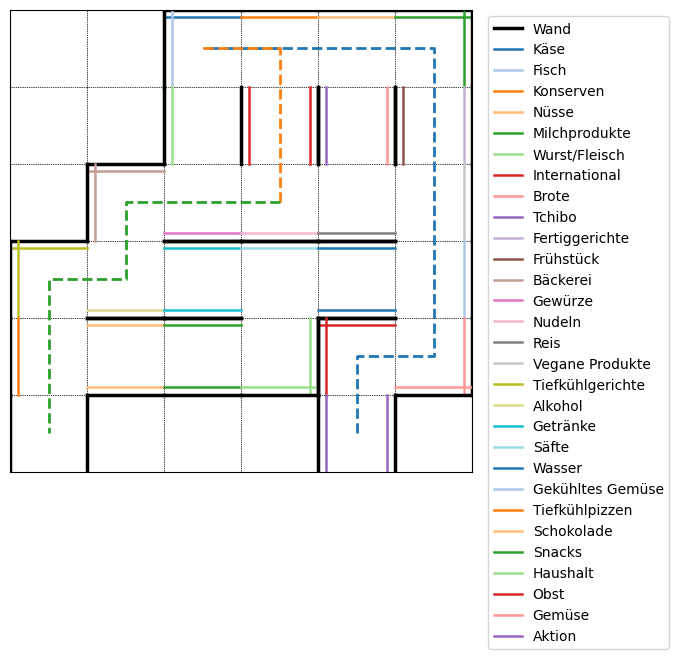

In [6]:
def create_product_cost_path_matrix(shopping_list, product_type_cost_matrix, product_type_path_matrix, product_type_indizes):
    """
    Creates cost and path matrices specifically for the products in a shopping list, 
    including the start and end points, by mapping from the full product type matrices.

    Procedure:
        1. Adds "start" and "end" to the shopping list.
        2. Initializes empty matrices for:
            - product_cost_matrix: stores the path length (cost) between each pair of shopping list items
            - product_path_matrix: stores the actual path (list of coordinates) between each pair
        3. Creates a mapping from shopping list item names to their indices in the matrices.
        4. Fills the matrices by looking up the costs and paths in the full product type matrices 
           using the corresponding product type indices.

    Parameters:
        - shopping_list: dictionary mapping item names to their product types
        - product_type_cost_matrix: full cost matrix for all product types (from compute_optimal_trajectories)
        - product_type_path_matrix: full path matrix for all product types
        - product_type_indizes: dictionary mapping product types to their indices in the full matrices

    Returns:
        - product_cost_matrix: 2D NumPy array with path lengths between shopping list items
        - product_path_matrix: 2D NumPy array with paths (lists of coordinates) between shopping list items
        - product_indizes: dictionary mapping shopping list item names to their indices in the returned matrices
    """
    # Add start and end to shopping-list
    if "start" not in shopping_list:
        shopping_list = {"start": "start", **shopping_list}
    if "end" not in shopping_list:
        shopping_list["end"] = "end"

    number_of_products = len(shopping_list)
    product_cost_matrix = np.empty((number_of_products, number_of_products), dtype=object)
    product_path_matrix = np.empty((number_of_products, number_of_products), dtype=object)

    # Create a mapping from shopping list item names to their indices in the matrices.
    product_indizes = {}
    i = 0
    for product in shopping_list:
        product_indizes[product] = i
        i += 1
    
    for product_start, product_type_start in shopping_list.items():
        for product_end, product_type_end in shopping_list.items():
            i_product_start = product_indizes[product_start]
            i_product_end = product_indizes[product_end]
            i_product_type_start = product_type_indizes[product_type_start]
            i_product_type_end = product_type_indizes[product_type_end]
            product_cost_matrix[i_product_start, i_product_end] = product_type_cost_matrix[i_product_type_start, i_product_type_end]
            product_path_matrix[i_product_start, i_product_end] = product_type_path_matrix[i_product_type_start, i_product_type_end]
    return product_cost_matrix, product_path_matrix, product_indizes    

shopping_list = {
    "Cheddar": "Käse",
    "Cashews": "Nüsse",
    "Penne": "Nudeln",
    "Pizza": "Tiefkühlgerichte",
    "Bandnudeln": "Nudeln",
    "Blumen": "Aktion"
}
product_cost_matrix, product_path_matrix, product_indizes = create_product_cost_path_matrix(shopping_list, product_type_cost_matrix, product_type_path_matrix, product_type_indizes)

#path = ("Penne", "Blumen")
#print(f"Path from {path[0]} to {path[1]}")
#plot_grid(grid, [product_path_matrix[product_indizes[path[0]], product_indizes[path[1]]]])
plot_grid(grid, [product_path_matrix[0, 1], product_path_matrix[1, 3], product_path_matrix[3, 7]])


## Easy heuristic for optimal route by length  
Unfortunaltely this computation scales by n!, where n is the number of items on the shopping list. Therefore this might not be the preferred algorithm for big shopping_lists.

[0, 6, 2, 1, 3, 5, 4, 7] 18


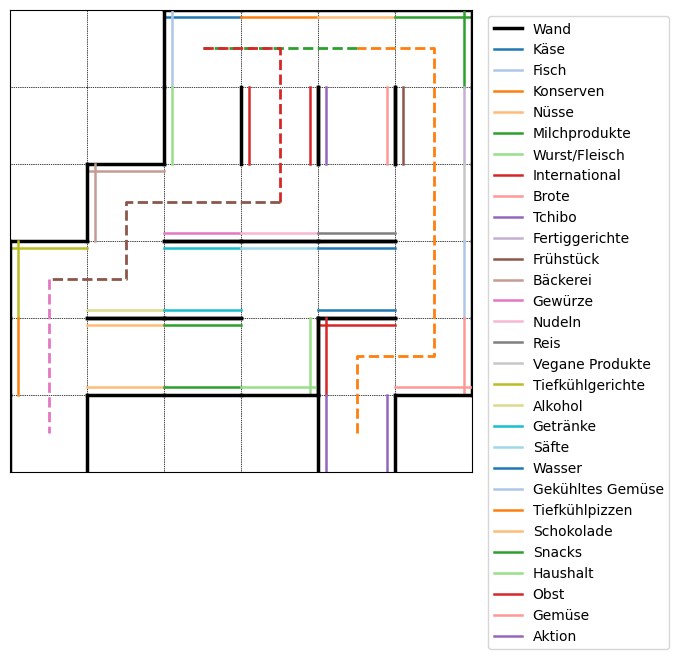

In [7]:
from itertools import permutations

def compute_timecost(order, product_cost_matrix):
    total_cost = 0
    for i in range(len(order)-1):
        total_cost += product_cost_matrix[order[i], order[i+1]]
    return total_cost

def get_path_from_order(order, product_path_matrix):
    path = []
    for i in range(len(order)-1):
        path.append(product_path_matrix[order[i], order[i+1]])
    return path

def get_complete_order(middle_indices_order, start_index, end_index):
    return [start_index]+middle_indices_order+[end_index]

def find_shortest_way_easy_heuristic(product_cost_matrix):
    n = product_cost_matrix.shape[0]
    start_index = 0
    end_index = n-1

    middle_indices = list(range(1, n-1))
    best_cost = np.inf
    best_order = None

    for order in permutations(middle_indices):
        full_order = get_complete_order(list(order), start_index, end_index)
        cost = compute_timecost(full_order, product_cost_matrix)
        if cost < best_cost:
            best_cost = cost
            best_order = full_order

    return best_order, best_cost



shortest_order, shortest_order_cost = find_shortest_way_easy_heuristic(product_cost_matrix)
shortest_path = get_path_from_order(shortest_order, product_path_matrix)
print(shortest_order, shortest_order_cost)
plot_grid(grid, shortest_path)